#Transfer Learning

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
import numpy as np
import random
random_seed = 1109

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)

def _init_fn(worker_id):
    np.random.seed(int(random_seed))

#With Data Transform

##With LR 0.001

###Load Data

In [71]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2, worker_init_fn=_init_fn)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

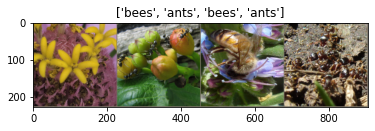

In [72]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###Training the model

Training Func & Visualizing Func



In [73]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###Train All layers

In [75]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [76]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [77]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7094 Acc: 0.6148
val Loss: 0.5003 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.5954 Acc: 0.7254
val Loss: 0.5784 Acc: 0.7124

Epoch 2/24
----------
train Loss: 0.6635 Acc: 0.5943
val Loss: 0.6232 Acc: 0.6536

Epoch 3/24
----------
train Loss: 0.5853 Acc: 0.7049
val Loss: 0.8704 Acc: 0.6340

Epoch 4/24
----------
train Loss: 0.5780 Acc: 0.7049
val Loss: 0.5483 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.6229 Acc: 0.6516
val Loss: 0.7717 Acc: 0.5098

Epoch 6/24
----------
train Loss: 0.6373 Acc: 0.6598
val Loss: 0.5244 Acc: 0.7320

Epoch 7/24
----------
train Loss: 0.5684 Acc: 0.7213
val Loss: 0.5040 Acc: 0.7712

Epoch 8/24
----------
train Loss: 0.5499 Acc: 0.7213
val Loss: 0.4741 Acc: 0.7712

Epoch 9/24
----------
train Loss: 0.5356 Acc: 0.7336
val Loss: 0.5370 Acc: 0.7451

Epoch 10/24
----------
train Loss: 0.4423 Acc: 0.8238
val Loss: 0.4682 Acc: 0.7908

Epoch 11/24
----------
train Loss: 0.4605 Acc: 0.7828
val Loss: 0.4563 Acc: 0.8039

Ep

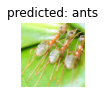

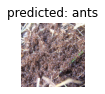

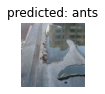

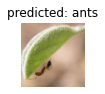

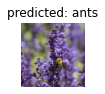

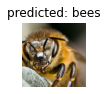

In [78]:
visualize_model(model_ft)

###Train Only FC layers

as feature extractor

In [79]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False
# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [80]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


Train and evaluate




In [81]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6564 Acc: 0.6107
val Loss: 0.4254 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4913 Acc: 0.7992
val Loss: 0.3224 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4712 Acc: 0.7787
val Loss: 0.2751 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3967 Acc: 0.8320
val Loss: 0.2557 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4703 Acc: 0.7582
val Loss: 0.2489 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3990 Acc: 0.7992
val Loss: 0.2316 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4384 Acc: 0.7951
val Loss: 0.2093 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3700 Acc: 0.8607
val Loss: 0.2110 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3669 Acc: 0.8320
val Loss: 0.2154 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3997 Acc: 0.8115
val Loss: 0.2157 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3228 Acc: 0.8689
val Loss: 0.2153 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3789 Acc: 0.8279
val Loss: 0.2133 Acc: 0.9412

Ep

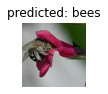

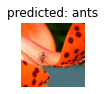

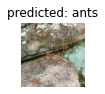

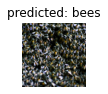

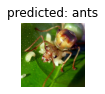

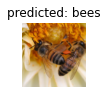

In [82]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With Lr 0.0001

###Train All layers

In [83]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [84]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [85]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5103 Acc: 0.7295
val Loss: 0.3084 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3517 Acc: 0.8689
val Loss: 0.2387 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3151 Acc: 0.8525
val Loss: 0.2206 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.2638 Acc: 0.9057
val Loss: 0.2129 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.3051 Acc: 0.8689
val Loss: 0.2712 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3479 Acc: 0.8525
val Loss: 0.2090 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3000 Acc: 0.8607
val Loss: 0.2449 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2823 Acc: 0.8934
val Loss: 0.2617 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3350 Acc: 0.8484
val Loss: 0.2434 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2739 Acc: 0.8852
val Loss: 0.2386 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2778 Acc: 0.8852
val Loss: 0.2087 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2804 Acc: 0.8770
val Loss: 0.3777 Acc: 0.8693

Ep

###Train Only FC layer

In [86]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False
# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [87]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [88]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6971 Acc: 0.5328
val Loss: 0.6525 Acc: 0.6928

Epoch 1/24
----------
train Loss: 0.6694 Acc: 0.6107
val Loss: 0.6236 Acc: 0.7320

Epoch 2/24
----------
train Loss: 0.6418 Acc: 0.6680
val Loss: 0.5807 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.6144 Acc: 0.7254
val Loss: 0.5467 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.6082 Acc: 0.7295
val Loss: 0.5294 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5640 Acc: 0.7541
val Loss: 0.4927 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.5566 Acc: 0.7746
val Loss: 0.4639 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.5512 Acc: 0.7787
val Loss: 0.4557 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.5377 Acc: 0.7787
val Loss: 0.4414 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.5199 Acc: 0.7992
val Loss: 0.4376 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.5048 Acc: 0.7992
val Loss: 0.4048 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.5184 Acc: 0.7541
val Loss: 0.3956 Acc: 0.9150

Ep

#With Only 224 Resize

other conditions are same as first case

##With LR 0.001

###Load Data

In [89]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Train All layers

In [90]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

In [91]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [92]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6742 Acc: 0.6434
val Loss: 1.7773 Acc: 0.6732

Epoch 1/24
----------
train Loss: 0.6724 Acc: 0.6434
val Loss: 0.6639 Acc: 0.6471

Epoch 2/24
----------
train Loss: 0.6724 Acc: 0.5820
val Loss: 0.8419 Acc: 0.6993

Epoch 3/24
----------
train Loss: 0.5926 Acc: 0.7131
val Loss: 0.9791 Acc: 0.4902

Epoch 4/24
----------
train Loss: 0.6346 Acc: 0.6148
val Loss: 0.6099 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.5793 Acc: 0.7254
val Loss: 0.5253 Acc: 0.7190

Epoch 6/24
----------
train Loss: 0.5970 Acc: 0.6926
val Loss: 0.5192 Acc: 0.7516

Epoch 7/24
----------
train Loss: 0.6308 Acc: 0.6721
val Loss: 0.6402 Acc: 0.7320

Epoch 8/24
----------
train Loss: 0.5992 Acc: 0.6762
val Loss: 0.5815 Acc: 0.7059

Epoch 9/24
----------
train Loss: 0.6053 Acc: 0.6885
val Loss: 0.6185 Acc: 0.7255

Epoch 10/24
----------
train Loss: 0.5693 Acc: 0.7459
val Loss: 1.7951 Acc: 0.5359

Epoch 11/24
----------
train Loss: 0.5892 Acc: 0.6926
val Loss: 0.5886 Acc: 0.7255

Ep

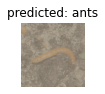

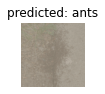

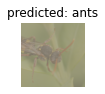

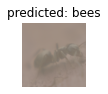

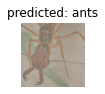

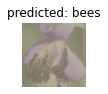

In [93]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [94]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False
# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

In [95]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [96]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6455 Acc: 0.6189
val Loss: 0.4568 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.4935 Acc: 0.7500
val Loss: 0.3224 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4032 Acc: 0.8238
val Loss: 0.3179 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4064 Acc: 0.8279
val Loss: 0.2420 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4207 Acc: 0.8156
val Loss: 0.2368 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4629 Acc: 0.7705
val Loss: 0.2640 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.4142 Acc: 0.7951
val Loss: 0.2211 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4014 Acc: 0.8402
val Loss: 0.2119 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4088 Acc: 0.7910
val Loss: 0.1933 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3262 Acc: 0.8689
val Loss: 0.2069 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3969 Acc: 0.8279
val Loss: 0.2022 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3957 Acc: 0.8197
val Loss: 0.2127 Acc: 0.9346

Ep

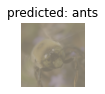

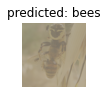

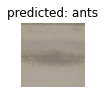

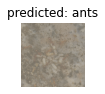

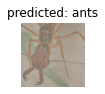

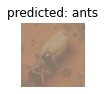

In [97]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##With LR 0.0001

###Train All Layers

In [98]:
model_ft = models.googlenet(pretrained=True)        #googlenet
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

In [99]:
#Freeze 된 layer 갯수 확인
Not_learnable = 0
for layer in model_ft.parameters():
    if not layer.requires_grad:
        Not_learnable += 1
print(Not_learnable)

0


In [100]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5170 Acc: 0.7705
val Loss: 0.2621 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.3793 Acc: 0.8484
val Loss: 0.2588 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.3522 Acc: 0.8484
val Loss: 0.2577 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3253 Acc: 0.8484
val Loss: 0.2580 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3071 Acc: 0.8607
val Loss: 0.2548 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.2330 Acc: 0.9016
val Loss: 0.2612 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3346 Acc: 0.8648
val Loss: 0.2302 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3131 Acc: 0.8443
val Loss: 0.2340 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3384 Acc: 0.8525
val Loss: 0.2056 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2635 Acc: 0.8730
val Loss: 0.2286 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2853 Acc: 0.8811
val Loss: 0.2348 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2631 Acc: 0.8893
val Loss: 0.1906 Acc: 0.9346

Ep

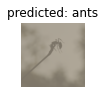

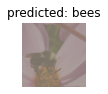

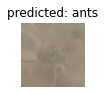

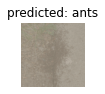

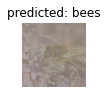

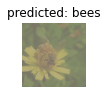

In [101]:
visualize_model(model_ft)

plt.ioff()
plt.show()

###Train Only FC layers

In [102]:
model_conv = torchvision.models.googlenet(pretrained=True)
# Freeze all params
for param in model_conv.parameters():
    param.requires_grad = False
# 새로 fc layer를 만들면서 requires_grad=True로 지정
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)

In [103]:
# Learnable Layer 갯수 확인
learnable = 0
for layer in model_conv.parameters():
    if layer.requires_grad:
        learnable += 1
print(learnable)        # weight and bias

2


In [104]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7061 Acc: 0.5164
val Loss: 0.6851 Acc: 0.5425

Epoch 1/24
----------
train Loss: 0.6761 Acc: 0.5656
val Loss: 0.6176 Acc: 0.7124

Epoch 2/24
----------
train Loss: 0.6340 Acc: 0.6639
val Loss: 0.5819 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.6054 Acc: 0.7541
val Loss: 0.5574 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5807 Acc: 0.7500
val Loss: 0.5216 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5697 Acc: 0.7377
val Loss: 0.5080 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5713 Acc: 0.7541
val Loss: 0.4728 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.5555 Acc: 0.7746
val Loss: 0.4660 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.5402 Acc: 0.7828
val Loss: 0.4485 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.5348 Acc: 0.7582
val Loss: 0.4234 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.5061 Acc: 0.7910
val Loss: 0.3994 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4920 Acc: 0.7910
val Loss: 0.3990 Acc: 0.9216

Ep

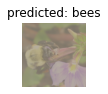

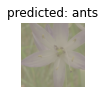

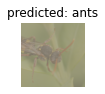

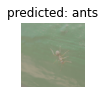

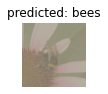

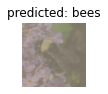

In [105]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#Further Learning

##Model Making

Train 함수를 약간 변형

- BCE Loss를 위해서 labels.float().view(-1,1)

In [106]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)        #pred = 0 or 1
                    loss = criterion(outputs, labels.float().view(-1,1))       #BCEWithLogit

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

1. Resnet의 adaptive average pool 2d를 adaptive max pool 2d로 교체

In [107]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [108]:
print(model.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [109]:
model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1,1))

In [110]:
print(model.avgpool)

AdaptiveMaxPool2d(output_size=(1, 1))


2. 마지막 fc layer와 batchnorm의 gamma, beta를 Learnable하게 변경

In [111]:
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# 새로 지정해서 requires_grad = True로 만들어줌
num_ftrs = model.fc.in_features

# -> BCELoss with Logit을 사용하기 위해 1로 마지막을 만든다
model.fc = nn.Linear(num_ftrs, 1)       

In [112]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [113]:
# BatchNorm이 있는 layer의 param을 learnable하게 만든다

for name, param in model.named_parameters():
    if 'bn' in name:
        param.requires_grad = True
    if 'downsample.1' in name:
        param.requires_grad = True

In [114]:
# 모든 layer의 param 체킹
for name, param in model.named_parameters():
    print(f'name:{name}') 
    print(type(param)) 
    print(f'param.shape:{param.shape}') 
    print(f'param.requries_grad:{param.requires_grad}') 
    print('=====')
    print()

name:conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 3, 7, 7])
param.requries_grad:False
=====

name:bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.bn1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True
=====

name:layer1.0.conv2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64, 64, 3, 3])
param.requries_grad:False
=====

name:layer1.0.bn2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:torch.Size([64])
param.requries_grad:True


3. 여러 조건들에서 Training

- Optimizer : Adam
- Lr : 0.0001
- Transform : 원본 그대로
- Batch size : 4, 16  
    -> DataLoader에서 바꿔야 함
- Loss function : Binary cross entropy with logit loss

##Batch 4

In [115]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/2021W_Postech_Study/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,      # Batch 4
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [116]:
model_batch4 = model.to(device)
criterion = nn.BCEWithLogitsLoss()      #Loss
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model_batch4.fc.parameters(), lr=0.0001)      #Adam, Lr

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [117]:
model_batch4 = train_model(model_batch4, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7912 Acc: 0.5041
val Loss: 0.7378 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.7732 Acc: 0.5041
val Loss: 0.6818 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.6921 Acc: 0.5041
val Loss: 0.6486 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.6956 Acc: 0.5041
val Loss: 0.5933 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.6605 Acc: 0.5041
val Loss: 0.5228 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.6331 Acc: 0.5041
val Loss: 0.5206 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.6025 Acc: 0.5041
val Loss: 0.4429 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.5809 Acc: 0.5041
val Loss: 0.4749 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.6238 Acc: 0.5041
val Loss: 0.4572 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.5952 Acc: 0.5041
val Loss: 0.4453 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.5655 Acc: 0.5041
val Loss: 0.4541 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.5461 Acc: 0.5041
val Loss: 0.4649 Acc: 0.4575

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


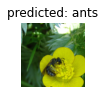

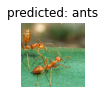

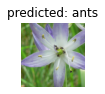

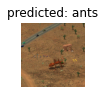

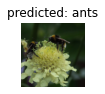

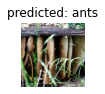

In [118]:
visualize_model(model_batch4)

plt.ioff()
plt.show()

##Batch 16

In [119]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,      #16
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [120]:
model_batch16 = model.to(device)

criterion = nn.BCEWithLogitsLoss()      #Loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model_batch16.fc.parameters(), lr=0.0001)      #Adam, Lr

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [121]:
model_batch16 = train_model(model_batch16, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7825 Acc: 0.5041
val Loss: 0.6787 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.7273 Acc: 0.5041
val Loss: 0.6294 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.6574 Acc: 0.5041
val Loss: 0.5892 Acc: 0.4575

Epoch 3/24
----------
train Loss: 0.6344 Acc: 0.5041
val Loss: 0.5659 Acc: 0.4575

Epoch 4/24
----------
train Loss: 0.6089 Acc: 0.5041
val Loss: 0.5317 Acc: 0.4575

Epoch 5/24
----------
train Loss: 0.5570 Acc: 0.5041
val Loss: 0.5149 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.6065 Acc: 0.5041
val Loss: 0.5086 Acc: 0.4575

Epoch 7/24
----------
train Loss: 0.5863 Acc: 0.5041
val Loss: 0.4910 Acc: 0.4575

Epoch 8/24
----------
train Loss: 0.5449 Acc: 0.5041
val Loss: 0.5150 Acc: 0.4575

Epoch 9/24
----------
train Loss: 0.5708 Acc: 0.5041
val Loss: 0.5004 Acc: 0.4575

Epoch 10/24
----------
train Loss: 0.5341 Acc: 0.5041
val Loss: 0.4873 Acc: 0.4575

Epoch 11/24
----------
train Loss: 0.5324 Acc: 0.5041
val Loss: 0.4841 Acc: 0.4575

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


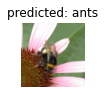

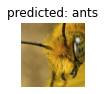

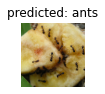

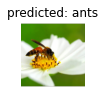

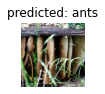

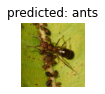

In [122]:
visualize_model(model_batch16)

plt.ioff()
plt.show()